# Summary

This file is a continuation of the previous 2 files. 



*   In the first file we setup the basic skeleton of the neural network
*   In the second file we reduced the number of parameters from ~6.4M to ~12.6K


Now, we want to address the overfitting aspect of the neural network and improve our test accuracy.


**Target**


1.   Address the Overfitting aspect of the neural network
2.   Reduce the number of parameters and get it to 8K-10K range
3.   Consistently hit the target test accuracy of 99.4%


**Result**

*   Total Model Parameters :  9,300
*   Best Train Accuracy :  100.0
*   Best Test Accuracy :  99.52
*   Number of Epochs with test accuracy above 99.4% threshold: 14


**Analysis**

1.   First, we addressed the overfitting issue by adding Batch Normalisation and simplifying the Neural network.
1.   Cut down the parameters from 6.4M to <10K
2.   The Test accuracy crossed the required threshold of 99.4% 14 times



## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# We use this experimental data to identify the mean and std dev of the dataset

# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Data Import & transformation

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmts
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 1, 28, 28])
torch.Size([64])


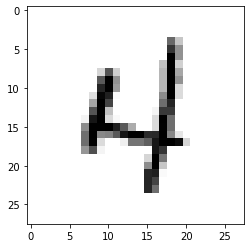

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


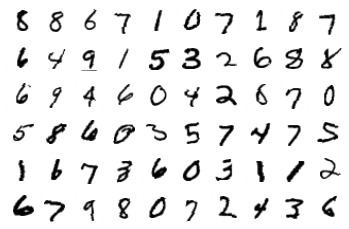

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

Defining the model & Initialising it

In [7]:
# We change the way we define the neural network. Earlier we used to work one convolution layer at a time, now we'll add more operations on top of the convolution layer
# All of this will fall under 1 block.
dropout_value = 0.15
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU()
        ) # Input - 28 x 28 x 1 | Output - 26 x 26 x 4 | RF - 3 | Kernel - 3 x 3 x 1 x 4

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # Input - 26 x 26 x 4 | Output - 24 x 24 x 8 | RF - 5 | Kernel - 3 x 3 x 4 x 8
        
        # TRANSITION BLOCK 1
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # Input - 24 x 24 x 8 | Output - 12 x 12 x 8 | RF - 10 | Kernel - 2 x 2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # Input - 12 x 12 x 8 | Output - 10 x 10 x 16 | RF - 12 | Kernel - 3 x 3 x 8 x 16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.Dropout(dropout_value)
          # If we increase the number of channels to 32, it increases the number of parameters by 4.6K, hence maintaining the channels at 16 
          # What is the benefit of having this block then? 
        ) # Input - 10 x 10 x 16 | Output - 10 x 10 x 16 | RF - 12 | Kernel - 3 x 3 x 16 x 16

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          # If we increase the number of channels to 32, it increases the number of parameters by 4.6K, hence maintaining the channels at 16 
          # What is the benefit of having this block then? 
        ) # Input - 8 x 8 x 16 | Output - 8 x 8 x 16 | RF - 14 | Kernel - 3 x 3 x 16 x 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # Input - 8 x 8 x 16 | Output - 6 x 6 x 16 | RF - 16 | Kernel - 3 x 3 x 16 x 16
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # Input - 6 x 6 x 16 | Output - 6 x 6 x 10 | RF - 18 | Kernel - 3 x 3 x 16 x 10
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1
        # ) # Input - 6 x 6 x 10 | Output - 1 x 1 x 10 | RF - 21 | Kernel - 6 x 6 x 10 x 10
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # ) # Input - 1 x 1 x 10 | Output - 1 x 1 x 10 | RF - 21 | Kernel - 1 x 1 x 10 x 10
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Parameters

In [8]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             288
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
            Conv2d-7           [-1, 16, 24, 24]             128
         MaxPool2d-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
      BatchNorm2d-10           [-1, 16, 10, 10]              32
             ReLU-11           [-1, 16, 10, 10]               0
          Dropout-12           [-1, 16, 10, 10]               0
           Conv2d-13           [-1, 16, 10, 10]             256
           Conv2d-14             [

## Training & Testing the Neural Network

Run the model and check 

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Testing our model

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.10401470959186554 Batch_id=937 Accuracy=88.78: 100%|██████████| 938/938 [00:22<00:00, 42.26it/s]



Test set: Average loss: 0.0695, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.02284197323024273 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:21<00:00, 42.80it/s]



Test set: Average loss: 0.0444, Accuracy: 9856/10000 (98.56%)

EPOCH: 2


Loss=0.032893504947423935 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:24<00:00, 38.71it/s]



Test set: Average loss: 0.0324, Accuracy: 9907/10000 (99.07%)

EPOCH: 3


Loss=0.043343685567379 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:22<00:00, 42.55it/s]



Test set: Average loss: 0.0263, Accuracy: 9917/10000 (99.17%)

EPOCH: 4


Loss=0.031206805258989334 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [00:22<00:00, 42.52it/s]



Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99.33%)

EPOCH: 5


Loss=0.01033899374306202 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:22<00:00, 42.16it/s]



Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 6


Loss=0.14788119494915009 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:22<00:00, 42.52it/s]



Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

EPOCH: 7


Loss=0.027754908427596092 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:23<00:00, 40.28it/s]



Test set: Average loss: 0.0188, Accuracy: 9950/10000 (99.50%)

EPOCH: 8


Loss=0.01776299998164177 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:22<00:00, 42.51it/s]



Test set: Average loss: 0.0177, Accuracy: 9950/10000 (99.50%)

EPOCH: 9


Loss=0.004315543919801712 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:22<00:00, 42.49it/s]



Test set: Average loss: 0.0167, Accuracy: 9950/10000 (99.50%)

EPOCH: 10


Loss=0.01589987426996231 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:22<00:00, 41.94it/s]



Test set: Average loss: 0.0174, Accuracy: 9952/10000 (99.52%)

EPOCH: 11


Loss=0.08307848870754242 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:22<00:00, 42.19it/s]



Test set: Average loss: 0.0164, Accuracy: 9952/10000 (99.52%)

EPOCH: 12


Loss=0.0017476874636486173 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:23<00:00, 40.45it/s]



Test set: Average loss: 0.0167, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.0071619353257119656 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:22<00:00, 41.75it/s]



Test set: Average loss: 0.0172, Accuracy: 9949/10000 (99.49%)

EPOCH: 14


Loss=0.008591747842729092 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:22<00:00, 42.19it/s]



Test set: Average loss: 0.0165, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Loss=0.0482780821621418 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:22<00:00, 42.31it/s]



Test set: Average loss: 0.0167, Accuracy: 9950/10000 (99.50%)

EPOCH: 16


Loss=0.025122059509158134 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:22<00:00, 42.38it/s]



Test set: Average loss: 0.0165, Accuracy: 9951/10000 (99.51%)

EPOCH: 17


Loss=0.015054437331855297 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:22<00:00, 41.46it/s]



Test set: Average loss: 0.0167, Accuracy: 9951/10000 (99.51%)

EPOCH: 18


Loss=0.045779768377542496 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:22<00:00, 42.01it/s]



Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH: 19


Loss=0.02385699562728405 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:22<00:00, 41.75it/s]



Test set: Average loss: 0.0164, Accuracy: 9949/10000 (99.49%)



In [11]:
import numpy as np
t = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

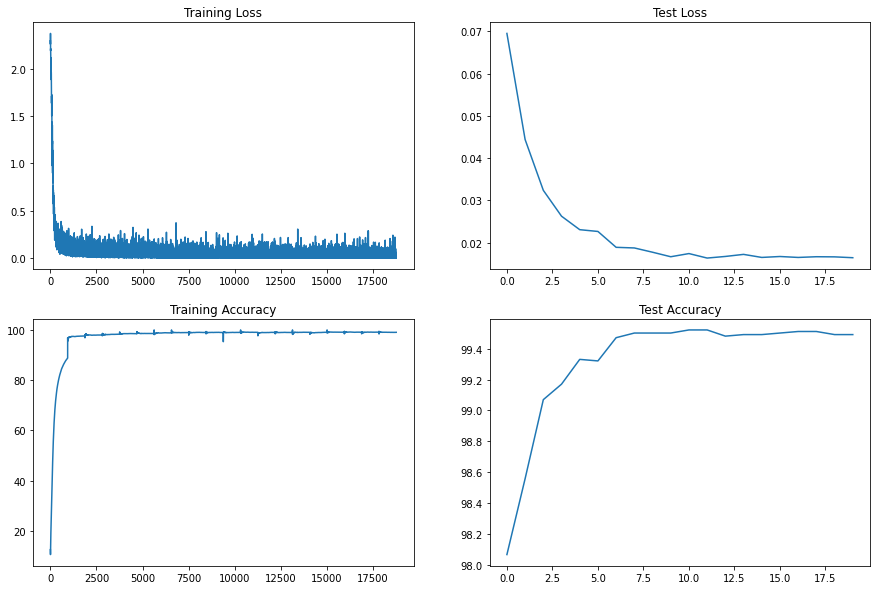

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

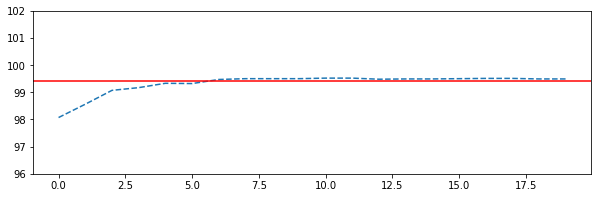

In [13]:
ymin = 96
ymax = 102
plt.figure(figsize=(10, 3))
#plt.plot(train_acc, label = 'train_acc', linestyle = "--")
plt.plot(test_acc, label = 'test_acc', linestyle = "--")
plt.axhline(y=99.4, color='r', linestyle='-')
plt.ylim(ymin, ymax)
plt.show()

In [14]:
print('Total Model Parameters : ', sum(p.numel() for p in model.parameters()))
print('Best Train Accuracy : ', max(train_acc))
print('Best Test Accuracy : ', max(test_acc))
x = [x for x in test_acc if x >= 99.4]
print('# of Epochs with test accuracy above 99.4% threshold:', len(x))

Total Model Parameters :  9300
Best Train Accuracy :  100.0
Best Test Accuracy :  99.52
# of Epochs with test accuracy above 99.4% threshold: 14
